In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import math 
from matplotlib.patches import Ellipse
#for removing warnings
import warnings

# Model data 

In [2]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
#data_path2 = 's3://data/vel_dataIII.zarr/vel_dataIII.zarr'
data_path1 = 's3://velocity-u.zarr'
data_path2 = 's3://velocity-v.zarr'
data_path3 = 's3://data/CREG12.L75-REF08_mesh_zgr.zarr'
remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)
remote_files3 = fsg.glob(data_path3)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
store3 = s3fs.S3Map(root=data_path3, s3=fsg, check=False)

du = xr.open_zarr(store=store1, consolidated=True)
dv = xr.open_zarr(store=store2, consolidated=True)
dzz = xr.open_zarr(store=store3, consolidated=True)

In [3]:
moor_l = [(836, 440),
            (838, 440),
            (836, 439),
            (915, 157), #Denne fikk nan value, hvorfor??
            (930, 149),
            (932, 147),
            (929, 142),
            (774, 344),
            (766, 358),
            (773, 346),
            (334, 978)]

vec_l = []

c_list = ['c', 'orangered', 'g',
          'r', 'm', 'y','tab:orange',
          'tab:pink', 'limegreen', 'maroon', 
          'dodgerblue', 'gold', 'peru','deeppink',
          'gold','peru','dodgerblue','c','m']

In [4]:
u = du.vozocrtx.isel(x=slice(200,1400),y=slice(650,1800))
u = u.rename({'depthu' : 'depth'})
v = dv.vomecrty.isel(x=slice(200,1400),y=slice(650,1800))
v = v.rename({'depthv' : 'depth'})

bathym = dzz.mbathy.isel(x=slice(200,1400),y=slice(650,1800)).squeeze(axis=0)

In [5]:
def PCz(data):
    cov = np.cov(data.T, bias=True) # uten .T ble den en 73x73 matrise     
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors

In [6]:
def PCz(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = bathym.isel(x=x, y=y).values

    dypu = u.isel(x=x, y=y, depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    dypv = v.isel(x=x, y=y, depth = slice(0,d-1))
    
    vecu, valu = PCz(dypu)
    vecv, valv = PCz(dypv)
    
    PC1u = (np.sqrt(valu[0])*vecu[:,0])
    PC1v = (np.sqrt(valv[0])*vecv[:,0])
    
    PVE1u = int(round(valu[0]/np.sum(valu)*100,0))
    PVE1v = int(round(valv[0]/np.sum(valv)*100,0))
    
    return PC1u, PC1v, dypu, dypv, PVE1u, PVE1v

def PCz_20(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = bathym.isel(x=x, y=y).values

    dypu = u.isel(x=x, y=y, depth = slice(15,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    dypv = v.isel(x=x, y=y, depth = slice(15,d-1))
    
    vecu, valu = PCz(dypu)
    vecv, valv = PCz(dypv)
    
    PC1u = (np.sqrt(valu[0])*vecu[:,0])
    PC1v = (np.sqrt(valv[0])*vecv[:,0])
    
    PVE1u = int(round(valu[0]/np.sum(valu)*100,0))
    PVE1v = int(round(valv[0]/np.sum(valv)*100,0))
    
    return PC1u, PC1v, dypu, dypv, PVE1u, PVE1v

'Making a function for the vertical PC'
def PCz_op(x,y, vec):
    
    d = bathym.isel(y=y, x=x).values
    up = u.isel(y=y, x=x, depth=d)
    vp = v.isel(y=y, x=x, depth=d)
    
    vel_p = (up*vec[0] + vp*vec[1])/(np.sqrt(vec[0]**2 + vec[1]**2))
    vel_o = (-up*vec[1] + vp*vec[0])/(np.sqrt(vec[0]**2 + vec[1]**2))
    
    vecp, valp = PCz(vel_p)
    veco, valo = PCz(vel_o)
    
    PC1p = (np.sqrt(valp[0])*vecp[:,0])
    PC1o = (np.sqrt(valo[0])*veco[:,0])
    
    PVE1p = int(round(valp[0]/np.sum(valp)*100,0))
    PVE1o = int(round(valo[0]/np.sum(valo)*100,0))
    
    return PC1p, PC1o, dyp_p, dyp_o, PVE1p, PVE1o

def ellipse(x,y,d):
    
    #d = bathym.isel(y=y, x=x).values
    covm = np.cov(np.vstack([u.isel(x=x, y=y, depth=d).values,v.isel(x=x, y=y, depth=d).values]))
    values_, vectors_ = np.linalg.eig(covm)
    order = values_.argsort()[::-1]
    values, vectors = values_[order], vectors_[:, order]
    
    # ellipser :
    major = np.sqrt(values[0])
    minor = np.sqrt(np.abs(values[1]))
    
    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = vectors[:,0][0], vectors[:,0][1]
    #theta = np.arctan(vy/vx)#*(180/math.pi)
    theta = np.arctan2(vy, vx)*(180/math.pi)
    
    return major, minor, theta, vectors

In [ ]:
d_l = [22,22,22,40,40,40,40,40,40,40,20]
maj_l = []
min_l = []
theta_l = []
vec_l = []

for i, m in enumerate(moor_l):
    print(i)
    x = m[0]
    y = m[1]
    d_ = d_l[i]
    maj_, min_, theta_, vec_ = ellipse(x,y,d_)
    maj_l.append(maj_)
    min_l.append(min_)
    theta_l.append(theta_)
    vec_l.append(vec_)
    
    

0


# starting with horizontal variance ellipses 

0.74
0.71
0.56
0.72


<ipython-input-35-6cf0c5fbebfb>:33: RuntimeWarning: invalid value encountered in double_scalars
  PVE = round((maj_**2/(maj_**2+ min_**2))*100,0)
<ipython-input-35-6cf0c5fbebfb>:34: RuntimeWarning: invalid value encountered in double_scalars
  velocity = round((maj_/(maj_+ min_)),2)


nan


<ipython-input-35-6cf0c5fbebfb>:33: RuntimeWarning: invalid value encountered in double_scalars
  PVE = round((maj_**2/(maj_**2+ min_**2))*100,0)
<ipython-input-35-6cf0c5fbebfb>:34: RuntimeWarning: invalid value encountered in double_scalars
  velocity = round((maj_/(maj_+ min_)),2)


nan


KeyboardInterrupt: 

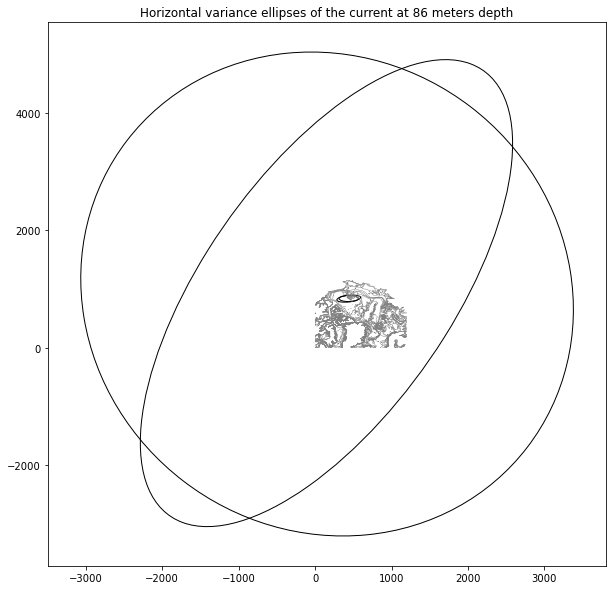

In [35]:
# Plot level 1
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.title(f'Horizontal variance ellipses of the current at 86 meters depth')
ax.contour(bathym, colors='grey',levels=8, linewidths=0.4)

for m in moor_l[0:2]:
    x = m[0]
    y = m[1]
    depth = 22
    
    maj_, min_, theta_, vec = ellipse(x,y,depth)
    PVE = round((maj_**2/(maj_**2+ min_**2))*100,0) 
    velocity = round((maj_/(maj_+ min_)),2) 
    print(velocity)
    s = 0.5e5
    ellipse_ = Ellipse((y,x), 
            width = maj_*2*s, 
            height = min_*2*s,
            angle = theta_,
            facecolor = 'none',
            edgecolor='k',
            label= f'PEV {PVE}%'
                     )
    vec_l.append(vec)
    ax.add_patch(ellipse_)
    
for m in moor_l[3:10]:
    x = m[0]
    y = m[1]
    depth = 40
    
    maj_, min_, theta_, vec = ellipse(x,y,depth)
    PVE = round((maj_**2/(maj_**2+ min_**2))*100,0) 
    velocity = round((maj_/(maj_+ min_)),2) 
    print(velocity)
    s = 0.5e5
    ellipse_ = Ellipse((y,x), 
            width = maj_*2*s, 
            height = min_*2*s,
            angle = theta_,
            facecolor = 'none',
            edgecolor='k',
            label= f'PEV {PVE}%'
                     )
    vec_l.append(vec)
    ax.add_patch(ellipse_)
    
for m in moor_l[10:]:
    x = m[0]
    y = m[1]
    depth = 20
    
    maj_, min_, theta_, vec = ellipse(x,y,depth)
    PVE = round((maj_**2/(maj_**2+ min_**2))*100,0) 
    velocity = round((maj_/(maj_+ min_)),2) 
    print(velocity)
    s = 0.5e5
    ellipse_ = Ellipse((y,x), 
            width = maj_*2*s, 
            height = min_*2*s,
            angle = theta_,
            facecolor = 'none',
            edgecolor='k',
            label= f'PEV {PVE}%'
                     )
    vec_l.append(vec)
    ax.add_patch(ellipse_)

ax.legend(frameon=False, fontsize=12, loc="upper left") 
    
#ax.set_xlim(750,950)
#ax.set_ylim(300,500)
ax.grid('on')
ax.set_aspect('equal')
plt.savefig('mood_ellipse_moor_loc.pdf', dpi = 300)

0.67
0.65


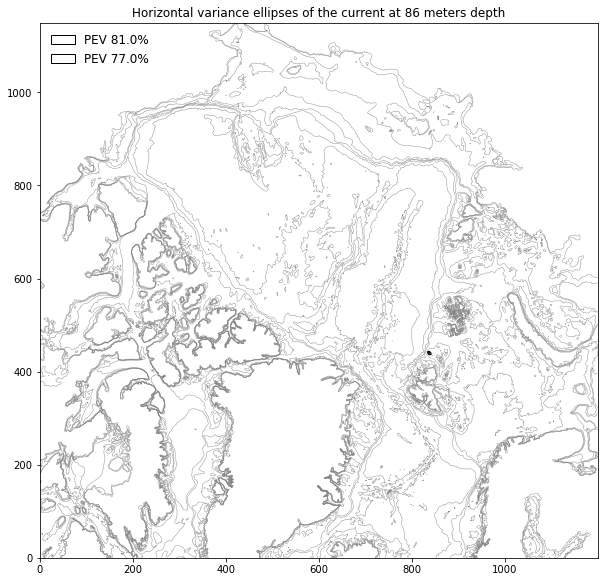

In [25]:
# Plot level 1
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.title(f'Horizontal variance ellipses of the current at 86 meters depth')
ax.contour(bathym, colors='grey',levels=8, linewidths=0.4)

for m in moor_l[0:2]:
    y = m[0]
    x = m[1]
    depth = 22
    
    maj_, min_, theta_, vec = ellipse(x,y,depth)
    PVE = round((maj_**2/(maj_**2+ min_**2))*100,0) 
    velocity = round((maj_/(maj_+ min_)),2) 
    print(velocity)
    s = 0.5e5 #stands for scale
    
    ellipse_ = Ellipse((y,x), 
            width = maj_*2*s, 
            height = min_*2*s,
            angle = theta_,
            facecolor = 'none',
            edgecolor='k',
            label= f'PEV {PVE}%'
                     )
    vec_l.append(vec)
    ax.add_patch(ellipse_)
    ax.legend(frameon=False, fontsize=12, loc="upper left") 
#ax.set_xlim(750,950)
#ax.set_ylim(300,500)


ax.set_aspect('equal')
#plt.savefig('mood_ellipse_moor_loc.pdf', dpi = 300)  

In [28]:
u

<xarray.DataArray 'vozocrtx' (time_counter: 73, depth: 75, y: 1150, x: 1200)>
dask.array<getitem, shape=(73, 75, 1150, 1200), dtype=float32, chunksize=(1, 75, 1150, 1200), chunktype=numpy.ndarray>
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float32 dask.array<chunksize=(1150, 1200), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1150, 1200), meta=np.ndarray>
    time_centered  (time_counter) object dask.array<chunksize=(73,), meta=np.ndarray>
  * time_counter   (time_counter) object 2000-01-03 12:00:00 ... 2000-12-29 1...
Dimensions without coordinates: y, x
Attributes:
    cell_methods:        time: mean (interval: 360 s)
    interval_operation:  360 s
    interval_write:      5 d
    long_name:           sea_water_x_velocity
    online_operation:    average
    standard_name:       sea_water_x_velocity
    units:               m/s

In [24]:
#vec_l = []

In [34]:
m = moor_l[0]
y = m[0]
x = m[1]
d_ = bathym.isel(x=x,y=y).values
print(d_)
u_ = u.isel(x=x,y=y,depth=d_) #.values
v_ = v.isel(x=x,y=y,depth=d_) #.values
#print(u_,v_)

65


# EOF Vertical and EOF rotated with major and minor axis from horizontal ellipses

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (20,11))
plt.suptitle('EOF1 from model data, Barents Sea', 
             horizontalalignment='center',
            fontsize=24)

axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [0,2,3]):
    pp = moor_l[i]
    print(pp[0], pp[1])    
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz(pp[0],pp[1])
        
    axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=12, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
fig.tight_layout()   

plt.savefig('EOF_Barents_mod.pdf', dpi = 300)

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (20,11))
plt.suptitle('EOF1 from model data rotated after variance ellipses, Barents sea', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [0,1,2]):
    pp = moor_l[i]
    vec = vec_l[i][:,0]
    print(pp[0], pp[1])    
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz_op(pp[0],pp[1],vec)
        
    axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOFrot_Barents_mod.pdf', dpi = 300)

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,4,figsize = (20,11))
plt.suptitle('EOF1 from model data, Lofoten Basin', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [3,4,5,6]):
    pp = moor_l[i]
    print(pp[0], pp[1])    
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz(pp[0],pp[1])
        
    axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOF_Lofoten_mod.pdf', dpi = 300)

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,4,figsize = (20,11))
plt.suptitle('EOF1 from model data rotated after variance ellipses, Lofoten Basin', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [3,4,5,6]):
    pp = moor_l[i]
    vec = vec_l[i][:,0]
    print(pp[0], pp[1])    
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz_op(pp[0],pp[1],vec)
        
    axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOFrot_Lofoten_mod.pdf', dpi = 300)

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,4,figsize = (20,11))
plt.suptitle('EOF1 from model data, Yermark Plateau', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [7,8,9]):
    pp = moor_l[i]
    print(pp[0], pp[1])    
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz(pp[0],pp[1])
        
    axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOF_Yermark_mod.pdf', dpi = 300)

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (20,11))
plt.suptitle('EOF1 from model data rotated after variance ellipses, Yermark Plateau', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [7,8,9]):
    pp = moor_l[i]
    vec = vec_l[i][:,0]
    print(pp[0], pp[1])    
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz_op(pp[0],pp[1],vec)
        
    axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOFrot_Yermark_mod.pdf', dpi = 300)

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,4,figsize = (20,11))
plt.suptitle('EOF1 from model data, Beaufort Shelf', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [10,11,12]):
    pp = moor_l[i]
    print(pp[0], pp[1])    
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz(pp[0],pp[1])
        
    axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOF_Beaufort_mod.pdf', dpi = 300)

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (20,11))
plt.suptitle('EOF1 from model data rotated after variance ellipses, Beaufort Shelf', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [10,11,12]):
    pp = moor_l[i]
    vec = vec_l[i][:,0]
    print(pp[0], pp[1])    
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz_op(pp[0],pp[1],vec)
        
    axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOFrot_Beaufort_mod.pdf', dpi = 300)